In [1]:
# Fix randomness and hide warnings
seed = 42
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [2]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [3]:
# Import other libraries
import cv2
from tensorflow.keras.applications.xception import preprocess_input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
from DataLoader import load_data

In [4]:
data_file = np.load("./public_data.npz", allow_pickle=True)
data = data_file["data"]
y = data_file["labels"]
y[y == "healthy"] = 0
y[y == "unhealthy"] = 1
y = y.astype(np.float32)

Removing trolls, shreks and duplicates


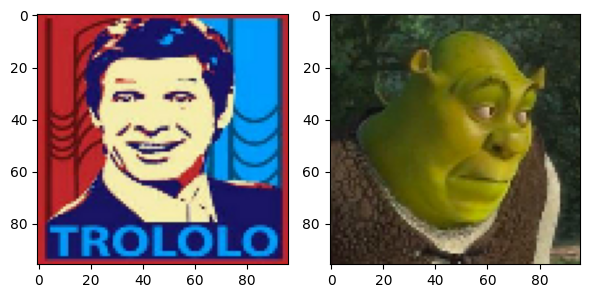

In [5]:
print("Removing trolls, shreks and duplicates")
initialDataN = data.shape[0]


troll = data[338]
shrek = data[58]


fig, axes = plt.subplots(1, 2, figsize=(6, 3))
axes[0].imshow(troll / 255)
axes[1].imshow(shrek / 255)
plt.tight_layout()
plt.show()

In [6]:
mask = []
for i in range(data.shape[0]):
    if np.array_equal(data[i], troll) or np.array_equal(data[i], shrek):
        mask.append(False)
    else:
        mask.append(True)
data = data[mask]
y = y[mask]

In [7]:
data, indexes = np.unique(data, axis=0, return_index=True)
y = y[indexes]

print("Removed Images: " + str(initialDataN - data.shape[0]))

Removed Images: 350


In [8]:
y = tfk.utils.to_categorical(y, num_classes=2)

In [9]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    data, y, random_state=seed, test_size=0.2, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, random_state=seed, test_size=0.2, stratify=y_train_val)

In [10]:
model = tfk.applications.Xception(
    input_shape=(96, 96, 3),
    include_top=False,
    weights="imagenet",
)

In [11]:
model.trainable = False

data_augmentation = tf.keras.Sequential([
    tfkl.RandomFlip("horizontal"),
    tfkl.RandomTranslation(0.1,0.1),
    tfkl.RandomRotation(0.1),
    tfkl.RandomZoom(0.1),
    tfkl.RandomBrightness(0.2),
    tfkl.RandomContrast(0.2),
])

inputs = tfk.Input(shape=(96, 96, 3))
x = data_augmentation(inputs)

scale_layer = tfkl.Rescaling(scale = 1/127.5, offset=-1)
x = scale_layer(x)

x = model(x, training=False)
x = tfkl.GlobalAveragePooling2D()(x)
x = tfkl.Dropout(0.2)(x)

output = tfkl.Dense(2, activation="softmax")(x)
tl_model = tfk.Model(inputs, output)
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 96, 96, 3)         0         
                                                                 
 rescaling (Rescaling)       (None, 96, 96, 3)         0         
                                                                 
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                             

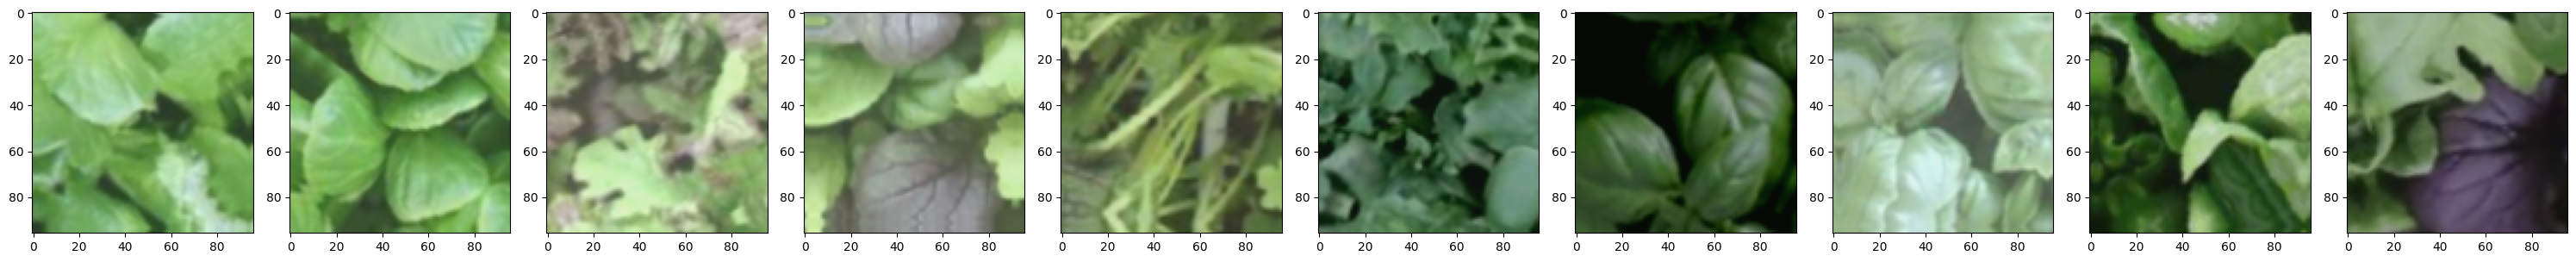

In [12]:
X_aug = data_augmentation(X_test)
fig, axes = plt.subplots(1, 10, figsize=(30, 3))
for i in range(10):
    axes[i].imshow(X_aug[i] / 255)
plt.tight_layout()
plt.show()

In [13]:
# Train the model
tl_history = tl_model.fit(
    x = X_train, # We need to apply the preprocessing
    y = y_train,
    batch_size = 16,
    epochs = 20,
    validation_data = (X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history

Epoch 1/20
194/194 [==============================] - 12s 41ms/step - loss: 0.6028 - accuracy: 0.6817 - val_loss: 0.5170 - val_accuracy: 0.7526
Epoch 2/20
194/194 [==============================] - 6s 32ms/step - loss: 0.5587 - accuracy: 0.7281 - val_loss: 0.5184 - val_accuracy: 0.7281
Epoch 3/20
194/194 [==============================] - 6s 32ms/step - loss: 0.5306 - accuracy: 0.7413 - val_loss: 0.5018 - val_accuracy: 0.7487
Epoch 4/20
194/194 [==============================] - 6s 32ms/step - loss: 0.5383 - accuracy: 0.7400 - val_loss: 0.5265 - val_accuracy: 0.7500
Epoch 5/20
194/194 [==============================] - 6s 32ms/step - loss: 0.5340 - accuracy: 0.7365 - val_loss: 0.4938 - val_accuracy: 0.7603
Epoch 6/20
194/194 [==============================] - 6s 32ms/step - loss: 0.5127 - accuracy: 0.7635 - val_loss: 0.4928 - val_accuracy: 0.7655
Epoch 7/20
194/194 [==============================] - 6s 32ms/step - loss: 0.5269 - accuracy: 0.7481 - val_loss: 0.5411 - val_accuracy: 0.741

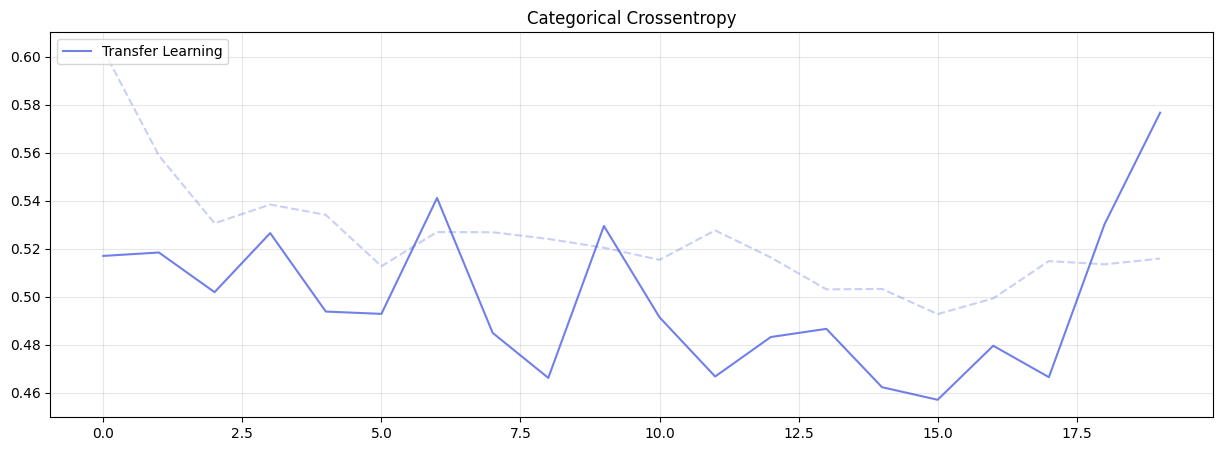

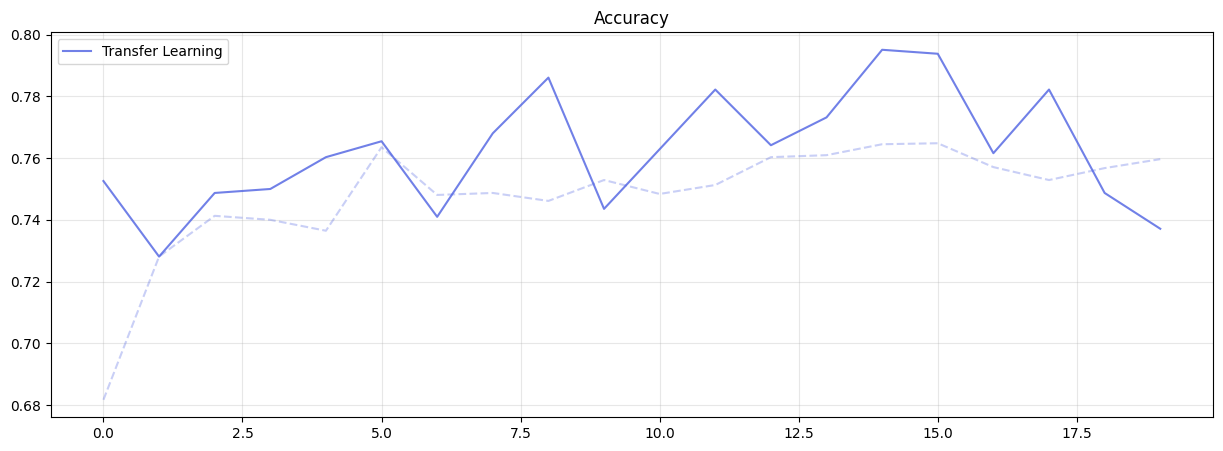

In [14]:
# Plot the re-trained and the transfer learning MobileNetV2 training histories
plt.figure(figsize=(15,5))
plt.plot(tl_history['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(tl_history['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [15]:
# Save the best model
tl_model.save('XceptionTransferLearning_AUG_HEAVY')
del tl_model

In [16]:
ft_model = tf.keras.models.load_model('XceptionTransferLearning_AUG_HEAVY')

In [17]:
ft_model.get_layer('xception').trainable = True

In [18]:
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-5), metrics=['accuracy'])


In [19]:
ft_history = ft_model.fit(
    x = X_train, # We need to apply the preprocessing
    y = y_train,
    batch_size = 16,
    epochs = 100,
    validation_data = (X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history

Epoch 1/100
194/194 [==============================] - 42s 117ms/step - loss: 0.4807 - accuracy: 0.7680 - val_loss: 0.4173 - val_accuracy: 0.8183
Epoch 2/100
194/194 [==============================] - 21s 109ms/step - loss: 0.4397 - accuracy: 0.8038 - val_loss: 0.4107 - val_accuracy: 0.8273
Epoch 3/100
194/194 [==============================] - 21s 109ms/step - loss: 0.3998 - accuracy: 0.8209 - val_loss: 0.4227 - val_accuracy: 0.8351
Epoch 4/100
194/194 [==============================] - 21s 108ms/step - loss: 0.3793 - accuracy: 0.8341 - val_loss: 0.4005 - val_accuracy: 0.8273
Epoch 5/100
194/194 [==============================] - 21s 108ms/step - loss: 0.3657 - accuracy: 0.8354 - val_loss: 0.4187 - val_accuracy: 0.8183
Epoch 6/100
194/194 [==============================] - 21s 109ms/step - loss: 0.3504 - accuracy: 0.8434 - val_loss: 0.3660 - val_accuracy: 0.8428
Epoch 7/100
194/194 [==============================] - 21s 109ms/step - loss: 0.3048 - accuracy: 0.8734 - val_loss: 0.3844 -

In [20]:
# Save the best model
ft_model.save('XceptionFineTuning_AUG_HEAVY')
del ft_model

: 